# BIBLIOTECAS


In [ ]:
%pip install scipy==1.15.2 spacy==3.8.4 nltk==3.9.1 scikit-learn==1.6.1 pandas==2.2.3 matplotlib==3.7.1

In [ ]:
%pip install gensim==4.3.3 scipy==1.11.4 transformers hf_xet tensorflow nlpaug

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

<span style="color: red; font-weight:bold">IMPORTANTE:</span> Reiniciar el kernel y seguir ejecutando a partir de aquí (no volver a instalar las librerias de las cendas anteriores) 


In [ ]:
import sys
import scipy
import spacy as sp
import nltk
import pandas as pd
import string
import numpy as np
import scipy.linalg as linalg
import nlpaug.augmenter.word as naw
from nltk import pos_tag, word_tokenize

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import matplotlib.pyplot as plt
from tensorflow.keras.utils import pad_sequences
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.regularizers import l2
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, Flatten, MaxPooling1D, SimpleRNN, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer

In [ ]:
nltk.download('punkt')       # Tokenizador
nltk.download('punkt_tab')
nltk.download('wordnet')     # Lemmatización
nltk.download('stopwords')   # Lista de palabras vacías (stopwords)
nltk.download('averaged_perceptron_tagger')  # Etiquetado gramatical
nltk.download('omw-1.4')     # WordNet para varios idiomas

In [ ]:
!python -m spacy download es_core_news_sm

# PREPROCESAMIENTO

In [8]:
input_file_train = r"C:\Users\fuenl\OneDrive - Universidad Rey Juan Carlos\Inteligencia Artificial\Tercero\Segundo Cuatrimestre\Procesamiento del Lenguaje Natural\Practica_Final\PracticaPLN\datasets\train.csv"
df_train = pd.read_csv(input_file_train)

# Se debe cambiar por el directorio donde se encuentra el archivo deseado en ambos casos

input_file_development = r"C:\Users\fuenl\OneDrive - Universidad Rey Juan Carlos\Inteligencia Artificial\Tercero\Segundo Cuatrimestre\Procesamiento del Lenguaje Natural\Practica_Final\PracticaPLN\datasets\development.csv"
df_dev = pd.read_csv(input_file_development)

In [ ]:
df_train.head()

In [11]:
ideology_map = {
    'left': 0,
    'moderate_left': 1,
    'moderate_right': 2,
    'right': 3
}

df_train['ideology_encoded'] = df_train['ideology_multiclass'].map(ideology_map)
df_dev['ideology_encoded'] = df_dev['ideology_multiclass'].map(ideology_map)

## Estudio del dataset

In [ ]:
list(df_train.columns)

['id',
 'label',
 'gender',
 'profession',
 'ideology_binary',
 'ideology_multiclass',
 'tweet',
 'ideology_encoded']

In [ ]:
df_train.nunique()

id                     28065
label                    313
gender                     2
profession                 2
ideology_binary            2
ideology_multiclass        4
tweet                  28065
ideology_encoded           4
dtype: int64

In [ ]:
df_train.head(5)

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet,ideology_encoded
0,37732,@user239,female,politician,right,moderate_right,"@user, propuestas de futuro 💪#no tocar las ref...",2
1,38447,@user13,female,journalist,left,left,@user @user Podemos entrar en bucle hasta el i...,0
2,10758,@user8,female,politician,left,moderate_left,👉🏻Como gallega me produce profunda decepción v...,1
3,33860,@user262,male,politician,right,right,"Y ahora, tras este raro de amable discusión so...",3
4,11677,@user341,female,politician,right,right,1-No se trata de defender o no la labor de @us...,3


Tweets

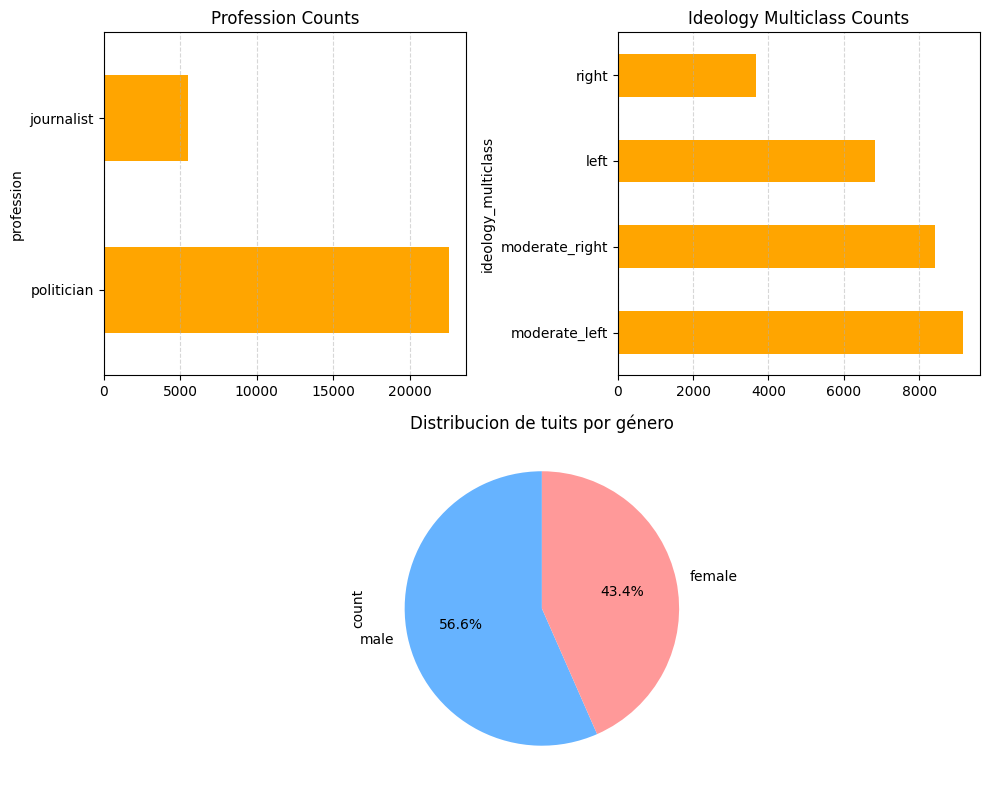

In [ ]:

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# profession 
ax1 = fig.add_subplot(gs[0, 0])
df_train['profession'].value_counts().plot(kind='barh', ax=ax1, color='orange')
ax1.set_title('Profession Counts')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# ideology_multiclass
ax2 = fig.add_subplot(gs[0, 1])
df_train['ideology_multiclass'].value_counts().plot(kind='barh', ax=ax2, color='orange')
ax2.set_title('Ideology Multiclass Counts')
ax2.grid(axis='x', linestyle='--', alpha=0.5)

# gender 
ax3 = fig.add_subplot(gs[1, :])
df_train['gender'].value_counts().plot(kind='pie', ax=ax3, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
ax3.set_title('Distribucion de tuits por género')
plt.tight_layout()
plt.show()

Usuarios únicos

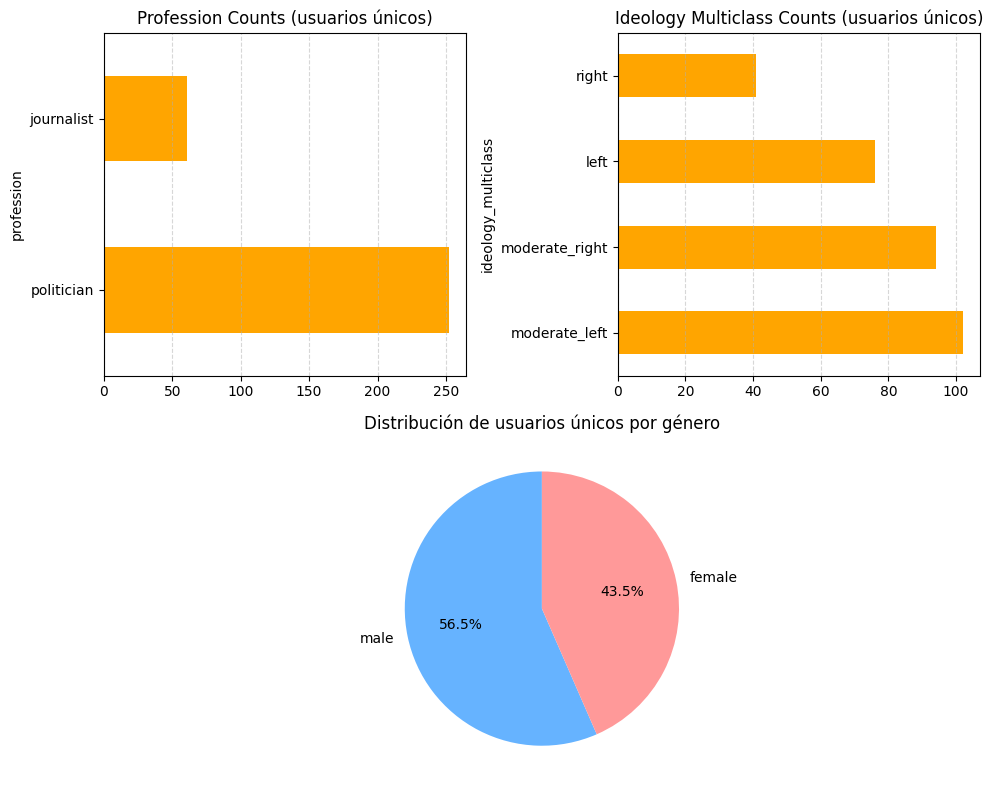

In [ ]:


fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# 1) Colapsar a un usuario único (un registro por 'label')
unique_users = df_train.drop_duplicates(subset='label')

# 2) Profesión (usuarios únicos)
ax1 = fig.add_subplot(gs[0, 0])
unique_users['profession'].value_counts().plot(kind='barh', ax=ax1, color='orange')
ax1.set_title('Profession Counts (usuarios únicos)')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# 3) Ideología multiclass (usuarios únicos)
ax2 = fig.add_subplot(gs[0, 1])
unique_users['ideology_multiclass'].value_counts().plot(kind='barh', ax=ax2, color='orange')
ax2.set_title('Ideology Multiclass Counts (usuarios únicos)')
ax2.grid(axis='x', linestyle='--', alpha=0.5)

# 4) Género de usuarios únicos (pie chart)
ax3 = fig.add_subplot(gs[1, :])
unique_users['gender'].value_counts().plot( kind='pie', ax=ax3, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999']  # azul para 'male', rosa para 'female'
)
ax3.set_ylabel('')
ax3.set_title('Distribución de usuarios únicos por género')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Número de usuarios únicos: {df_train['label'].nunique()}")

Número de usuarios únicos: 313


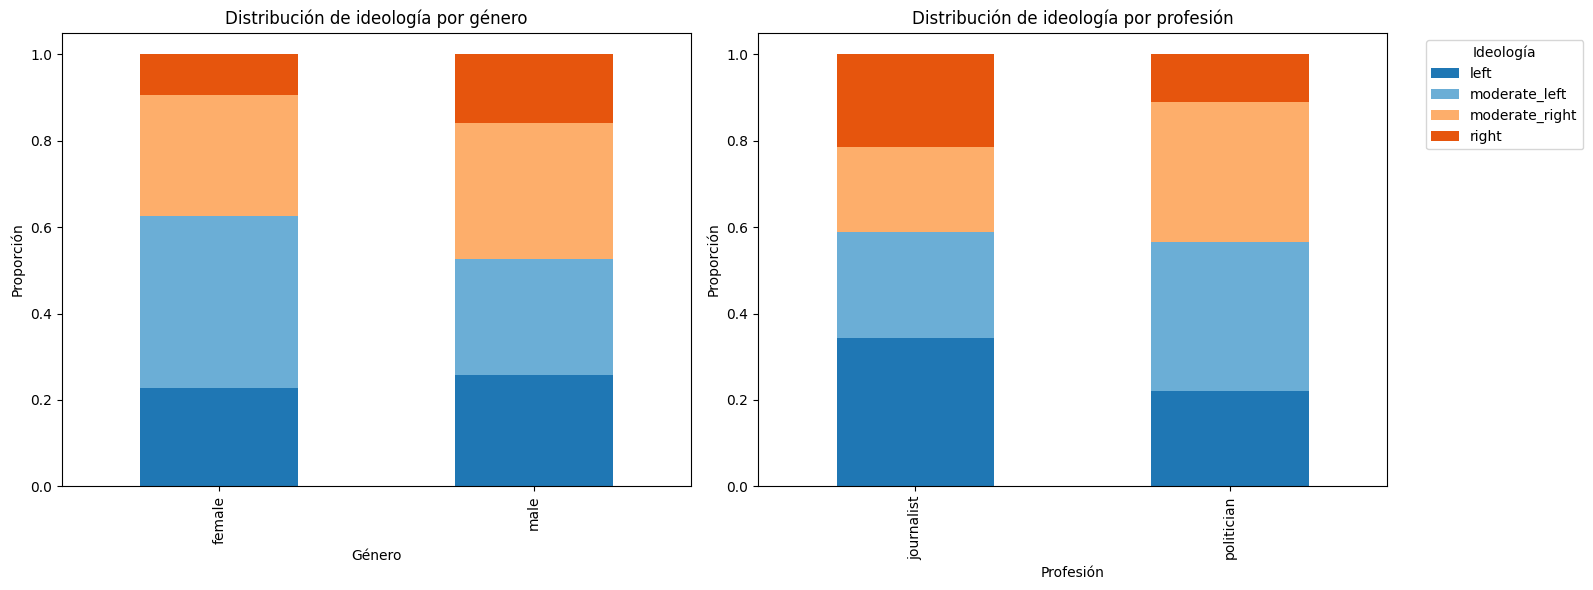

In [ ]:


# Cálculo de las tablas cruzadas
ct_gender = pd.crosstab(df_train['gender'], df_train['ideology_multiclass'], normalize='index')
ct_prof = pd.crosstab(df_train['profession'], df_train['ideology_multiclass'])
ct_prof_norm = ct_prof.div(ct_prof.sum(1), axis=0)

# Paleta de colores agrupada
palette = {
    'left': '#1f77b4',
    'moderate_left': '#6baed6',
    'moderate_right': '#fdae6b',
    'right': '#e6550d'
}

# Aseguramos el mismo orden de categorías en ambos
cats = ct_gender.columns.tolist()
colors = [palette[c] for c in cats]

# Creamos la figura con dos subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Género vs ideología (barras verticales apiladas)
ct_gender.plot(kind='bar',  stacked=True, color=colors, ax=axes[0], legend=False)
axes[0].set_title('Distribución de ideología por género')
axes[0].set_ylabel('Proporción')
axes[0].set_xlabel('Género')

# 2) Profesión vs ideología (también vertical apilado)
ct_prof_norm.plot(kind='bar', stacked=True, color=colors, ax=axes[1])
axes[1].set_title('Distribución de ideología por profesión')
axes[1].set_ylabel('Proporción')
axes[1].set_xlabel('Profesión')
axes[1].legend(title='Ideología', bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()


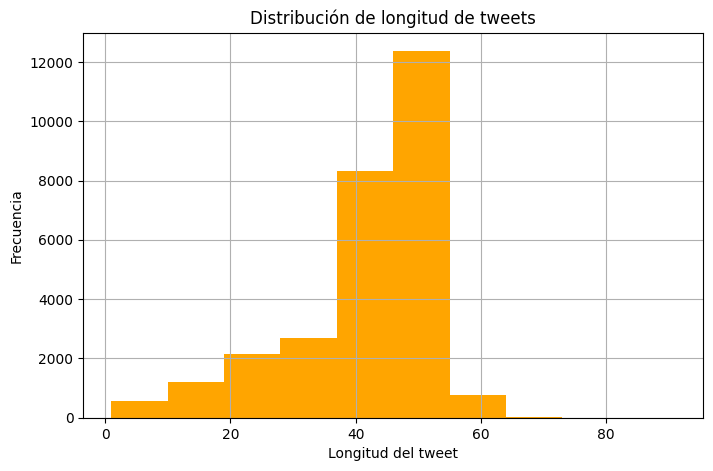

In [ ]:
df_train['tweet'].str.split().map(lambda x: len(x)).hist(color='orange', figsize=(8, 5))
plt.xlabel('Longitud del tweet')
plt.ylabel('Frecuencia')
plt.title('Distribución de longitud de tweets')
plt.show()

## Clase Preprocesamiento

In [16]:
class TweetProcessor:
    def __init__(self,
                 model="es_core_news_sm",
                 disable_components=("parser", "ner"),
                 remove_stop=True,
                 remove_punct=True,
                 remove_space=True,
                 remove_emojis=True,
                 remove_mentions=True):
        # Carga de spaCy
        self.nlp = sp.load(model, disable=list(disable_components))

        # Configuraciones de filtrado
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_space = remove_space
        self.remove_emojis = remove_emojis
        self.remove_mentions = remove_mentions

        # Patrón para detectar emojis
        self.emoji_pattern = re.compile(
            "[" 
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002700-\U000027BF"
            u"\U000024C2-\U0001F251"
            "]+",
            flags=re.UNICODE
        )

        # Espacios para almacenar resultados
        self._tweets_tokenized = {}
        self._tweets_pos_tags = {}


    def _should_keep(self, token):
        """Decide si un token pasa todos los filtros."""
        if self.remove_stop and token.is_stop:
            return False
        if self.remove_punct and token.is_punct:
            return False
        if self.remove_space and token.is_space:
            return False
        if self.remove_mentions and token.text.startswith('@'):
            return False
        if self.remove_emojis and self.emoji_pattern.fullmatch(token.text):
            return False
        return True


    def process(self, df):
        """
        Procesa un DataFrame con columnas 'id' y 'tweet'.
        Rellena self._tweets_tokenized y self._tweets_pos_tags.
        """
        for tw_id, text in zip(df['id'], df['tweet'].str.lower()):
            doc = self.nlp(text)
            filtered = [token for token in doc if self._should_keep(token)]
            
            # Guardamos la versión lematizada
            lemmas = [token.lemma_ for token in filtered]
            self._tweets_tokenized[tw_id] = " ".join(lemmas)
            # Guardamos (lema, POS)
            self._tweets_pos_tags[tw_id] = [(token.lemma_, token.pos_) for token in filtered]
        return self
 
        
    def filter_by_pos(self, pos_to_erase):
        """
        Devuelve un nuevo diccionario tokenizado, eliminando las POS indicadas.
        
        pos_to_erase: iterable de etiquetas POS (p. ej. ['NOUN','ADJ'])
        """
        to_erase = set(pos_to_erase)
        filtered = {}
        for tw_id, text in self._tweets_tokenized.items():
            pos_list = self._tweets_pos_tags.get(tw_id, [])
            lemmas = [lemma for lemma, pos in pos_list if pos not in to_erase]
            filtered[tw_id] = " ".join(lemmas)
        return filtered


    # —— Vocabulario —— #

    def build_vocab(self, text, vocab_size=1000):
        vocab = {}
        index = 1
        
        if len(text) == 0:
            raise ValueError("No hay tweets procesados. Asegúrate de llamar a process() primero.")
        else:
            for tw in text:
                for token in tw.split():
                    if index < vocab_size and token not in vocab:
                        vocab[token] = index
                        index += 1
                    elif index >= vocab_size:
                        break
        return vocab
    

    def text_encoder(self, text, vocab, max_len=100):
        encoded_text = []
        
        for tw in text:
            encoded_tweet = []
            for token in tw.split():
                if token in vocab:
                    encoded_tweet.append(vocab[token])
                else:
                    encoded_tweet.append(0)
            encoded_text.append(encoded_tweet)

        encoded_text = pad_sequences(encoded_text, maxlen=max_len, padding='post', truncating='post')
        
        return encoded_text

    # —— getters —— #
    def get_tokenized_tweets(self):
        """Devuelve el dict {tweet_id: lemas_concatenados}."""
        return self._tweets_tokenized

    def get_pos_tags(self):
        """Devuelve el dict {tweet_id: [(lemma, POS), ...]}."""
        return self._tweets_pos_tags
    
    
    
    

In [ ]:
processor = TweetProcessor(remove_emojis=True, remove_mentions=True)
processor.process(df_train)

processor_dev = TweetProcessor(remove_emojis=True, remove_mentions=True)
processor_dev.process(df_dev)


In [18]:
# Obtener el dict de lemas
tokenized = processor.get_tokenized_tweets()
tokenized_dev = processor_dev.get_tokenized_tweets()

# Obtener el dict de POS-tags
#pos_tags = processor.get_pos_tags()

# Filtrar sustantivos y adjetivos
#sin_noun_adj = processor.filter_by_pos(['NOUN', 'ADJ'])

# Representaciones BoW, TF-IDF...

In [15]:
def vectorizado_BOW_binario(corpus):
    vectorizerBOW = CountVectorizer(binary=True)
    solucion = vectorizerBOW.fit_transform(corpus)
    return vectorizerBOW.get_feature_names_out(), solucion.toarray()

def vectorizado_BOW(corpus):
    vectorizerBOW = CountVectorizer()
    solucion = vectorizerBOW.fit_transform(corpus)
    return vectorizerBOW.get_feature_names_out(), solucion.toarray()

def vectorizado_TFIDF(corpus):
    vectorizerTfidf = TfidfVectorizer()
    solucion = vectorizerTfidf.fit_transform(corpus)
    return vectorizerTfidf.get_feature_names_out(), solucion.toarray()

In [10]:
words, bow = vectorizado_BOW(tokenized.values())
print(words)
print(bow.max())

['00' '000' '0000' ... '𝟬𝟬𝟬𝗠' '𝟭𝟭' '𝟮𝟳']
17


# EMBEDDINGS ESTÁTICOS



In [ ]:


# Convertir el diccionario de tweets (tweets_tokenized) en una lista de frases tokenizadas

tokenized_sentences = [tweet.split() for tweet in tokenized.values()]

# Instanciar y cargar los diferentes modelos
modelo_w2v = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)
modelo_fasttext = FastText(tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)
modelo_glove = api.load("glove-wiki-gigaword-300")


# Función que convierte cada lista de tokens o token en vectores dependiendo del modelo

def tweet_to_vector(tokens, modelo, tipo='gensim'):
    vectores = []

    if tipo == 'gensim':
        for word in tokens:
            if word in modelo.wv:
                vectores.append(modelo.wv[word])
    elif tipo == 'glove':
        for word in tokens:
            if word in modelo:
                vectores.append(modelo[word])
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(100)   


vectores_w2v = {tw_id: tweet_to_vector(tweet.split(), modelo_w2v, tipo='gensim') for tw_id, tweet in tokenized.items()}
vectores_fasttext = {tw_id: tweet_to_vector(tweet.split(), modelo_fasttext, tipo='gensim') for tw_id, tweet in tokenized.items()}
vectores_glove = {tw_id: tweet_to_vector(tweet.split(), modelo_glove, tipo='glove') for tw_id, tweet in tokenized.items()}



In [ ]:


# Asegurarse de que los vectores y las etiquetas tengan el mismo número de muestras
common_ids = set(vectores_w2v.keys()).intersection(df_train['id'])
filtered_vectores_w2v = {tw_id: vectores_w2v[tw_id] for tw_id in common_ids}

# Convertir los vectores_w2v a una matriz de características y obtener las etiquetas
X = np.array(list(filtered_vectores_w2v.values()))
y = df_train[df_train['id'].isin(common_ids)]['ideology_encoded'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un clasificador Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.2989488686976661
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.15      0.18      1315
           1       0.33      0.48      0.39      1885
           2       0.29      0.35      0.32      1666
           3       0.19      0.01      0.02       747

    accuracy                           0.30      5613
   macro avg       0.26      0.25      0.23      5613
weighted avg       0.28      0.30      0.27      5613



# EMBEDDINGS CONTEXTUALES

In [ ]:

# Cargar el modelo y el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Función para obtener embeddings contextuales de un texto
def obtener_embeddings_bert(texto, tokenizer, model):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usamos la salida de la capa oculta (hidden states) como embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Generar embeddings para los tweets tokenizados
vectores_bert = {tw_id: obtener_embeddings_bert(tweet, tokenizer, model) for tw_id, tweet in tokenized.items()}

In [ ]:


# Asegurarse de que los vectores y las etiquetas tengan el mismo número de muestras
common_ids = set(vectores_bert.keys()).intersection(df_train['id'])
filtered_vectores_bert = {tw_id: vectores_bert[tw_id] for tw_id in common_ids}

# Convertir los vectores_bert a una matriz de características y obtener las etiquetas
X_bert = np.array(list(filtered_vectores_bert.values()))
y_bert = df_train[df_train['id'].isin(common_ids)]['ideology_encoded'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

# Entrenar un clasificador Random Forest
clf_bert = RandomForestClassifier(random_state=42)
clf_bert.fit(X_train_bert, y_train_bert)

# Predecir en el conjunto de prueba
y_pred_bert = clf_bert.predict(X_test_bert)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test_bert, y_pred_bert))
print("Classification Report:\n", classification_report(y_test_bert, y_pred_bert))

Accuracy: 0.3021557099590237
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.10      0.15      1315
           1       0.33      0.55      0.41      1885
           2       0.28      0.31      0.29      1666
           3       0.00      0.00      0.00       747

    accuracy                           0.30      5613
   macro avg       0.21      0.24      0.21      5613
weighted avg       0.25      0.30      0.26      5613



# Modelos de aprendizaje automático clásicos

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

# 2. Define los clasificadores en pipelines (con escalado donde convenga)
models = {
    "Naive Bayes": Pipeline([
        ("nb", GaussianNB())
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),           # la Regresión Logístico se beneficia del escalado
        ("lr", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),           # el SVM requiere datos escalados
        ("svm", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
}

# 3. Entrena y evalúa cada modelo
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()

--- Naive Bayes ---
Accuracy: 0.27774808480313556
              precision    recall  f1-score   support

           0       0.25      0.25      0.25      1315
           1       0.34      0.39      0.36      1885
           2       0.29      0.24      0.26      1666
           3       0.13      0.13      0.13       747

    accuracy                           0.28      5613
   macro avg       0.25      0.25      0.25      5613
weighted avg       0.27      0.28      0.27      5613


--- Logistic Regression ---
Accuracy: 0.2866559771957955
              precision    recall  f1-score   support

           0       0.22      0.16      0.19      1315
           1       0.32      0.44      0.37      1885
           2       0.28      0.33      0.30      1666
           3       0.14      0.02      0.04       747

    accuracy                           0.29      5613
   macro avg       0.24      0.24      0.22      5613
weighted avg       0.26      0.29      0.26      5613


--- SVM ---
Accuracy:

# MODELOS DE APRENDIZAJE PROFUNDO


## Visualizacion de métricas


In [7]:
import matplotlib.pyplot as plt
def grafics1(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    #
    # Curva accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Curva loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'b', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

In [8]:
def plot_metrics(model, x_test, y_test):
    
    #  Evaluación rápida con model.evaluate
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {acc:.4f}")

    #  Predicciones y métricas detalladas

    #  Obtener probabilidades y clases predichas
    y_pred_probs   = model.predict(x_test, verbose=0)    # shape (n_samples, n_classes)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)            # shape (n_samples,)

    #  Accuracy
    acc_manual = accuracy_score(y_test, y_pred_classes)
    print(f"\nAccuracy (sklearn): {acc_manual:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true=y_test,
        y_pred=y_pred_classes,
        digits=4
    ))

    #  Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)


    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm)  # usa el colormap por defecto
    ax.set_title('Matriz de Confusión')
    ax.set_xlabel('Etiqueta Predicha')
    ax.set_ylabel('Etiqueta Verdadera')

    # Poner las marcas de los ejes
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))

    # Anotar cada casilla con su valor
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, val, ha='center', va='center')

    fig.tight_layout()
    plt.show()

## CNN


##### CNN Simple 

Capas:
- Embedding ()
- Conv1D (128 filtros, kernel_size=5, activación ReLU)
- MaxPooling1D (pool_size=2)
- Flatten
- Dense (128 neuronas, activación ReLU) para añadir no linealidad
- Dropout (0.5) para evitar sobreajuste (aunque no funciona muy bien...)
- Dense (4 neuronas, activación softmax) para clasificar en 4 clases

count    28065.000000
mean       137.364939
std         41.389121
min          0.000000
25%        118.000000
50%        146.000000
75%        165.000000
max        369.000000
Name: len_texts, dtype: float64


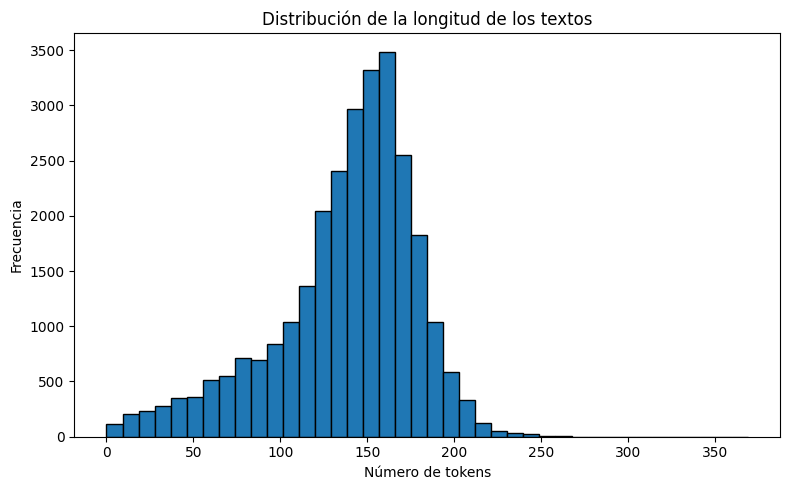

In [19]:
df_train['len_texts'] = [len(tweet) for tweet in tokenized.values()]


import matplotlib.pyplot as plt
print(df_train['len_texts'].describe())
plt.figure(figsize=(8, 5))
plt.hist(df_train['len_texts'], bins=40, edgecolor='black')
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de los textos")
plt.tight_layout()
plt.show()


In [20]:
from tensorflow.keras.utils import pad_sequences
vocab_size = 100000
embedding_dim = 100
df_train['len_texts'] = [len(tweet) for tweet in tokenized.values()]
max_length = max_length_texts = int(np.percentile(df_train['len_texts'], 80))

X_train = list(tokenized.values())
y_train = df_train['ideology_encoded'].values
seed = 42

X_val = list(tokenized_dev.values())
y_val = df_dev['ideology_encoded'].values



vocab = processor.build_vocab(X_train, vocab_size)                  # processor ya instanciado antes TweetProcessor


encoded_x_train = processor.text_encoder(X_train, vocab, max_len=max_length)
encoded_x_val = processor.text_encoder(X_val, vocab, max_len=max_length)




In [ ]:
cnn = Sequential()
cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)))
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(4, activation='softmax'))
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()



In [127]:
history = cnn.fit(encoded_x_train, y_train, epochs=10, batch_size=32, validation_data=(encoded_x_val, y_val), verbose=1)

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.4824 - loss: 1.1606 - val_accuracy: 0.5674 - val_loss: 1.0287
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.7723 - loss: 0.6130 - val_accuracy: 0.5535 - val_loss: 1.1301
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9412 - loss: 0.1889 - val_accuracy: 0.5299 - val_loss: 1.6783
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.9812 - loss: 0.0617 - val_accuracy: 0.5278 - val_loss: 2.3487
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.9913 - loss: 0.0254 - val_accuracy: 0.5253 - val_loss: 2.8610
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.9927 - loss: 0.0206 - val_accuracy: 0.5335 - val_loss: 3.4624
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.9939 - loss: 0.0173 - val_accuracy: 0.5328 - val_loss: 3.6676
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.9925 - loss: 0.0225 - 

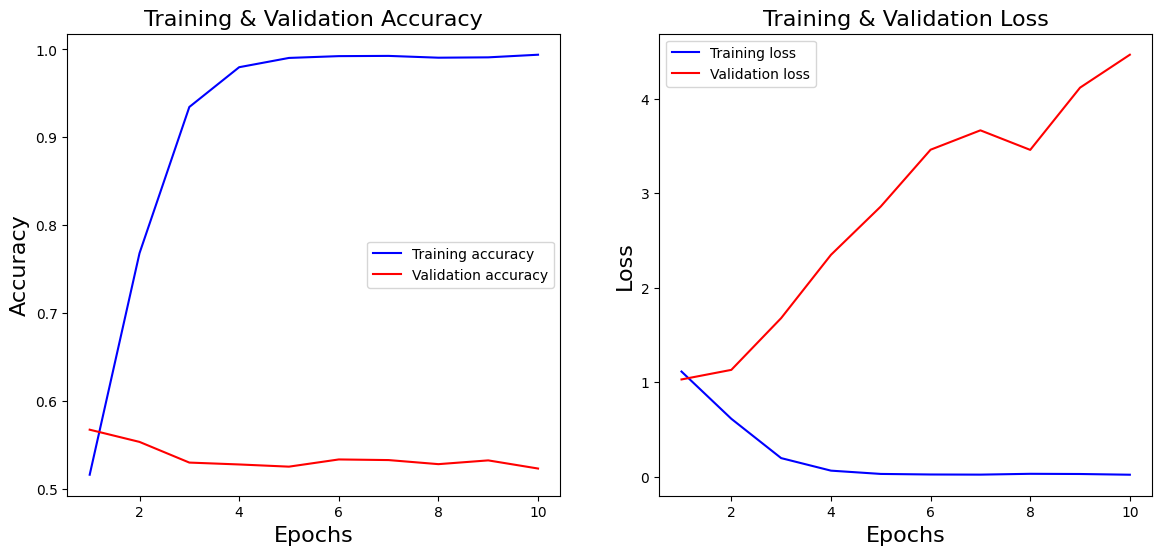

In [129]:
grafics1(history)

Test loss: 4.6291
Test accuracy: 0.5137

Accuracy (sklearn): 0.5137

Classification Report:
              precision    recall  f1-score   support

           0     0.5160    0.5190    0.5175       684
           1     0.5330    0.5644    0.5483       916
           2     0.5329    0.5386    0.5358       841
           3     0.3913    0.3197    0.3519       366

    accuracy                         0.5137      2807
   macro avg     0.4933    0.4854    0.4884      2807
weighted avg     0.5104    0.5137    0.5114      2807



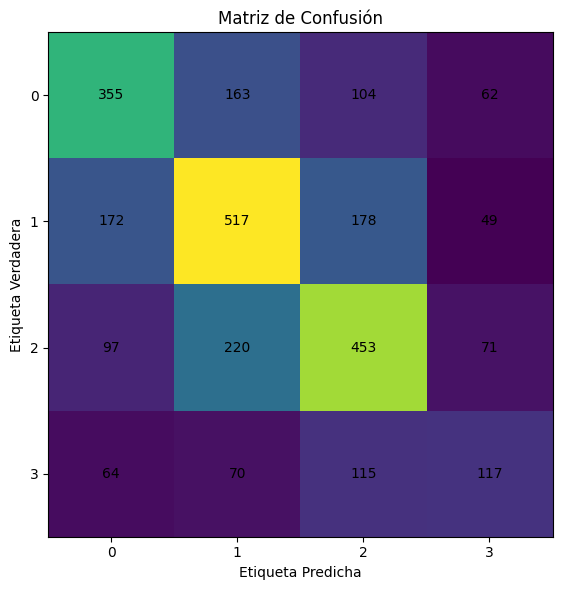

In [ ]:
plot_metrics(cnn, encoded_x_val, y_val)

### CNN con embeddings de word2vec

In [24]:
import gensim
from gensim.models import KeyedVectors
h_path = r'C:\Users\fuenl\OneDrive\Escritorio\SBW-vectors-300-min5.txt'
path = r'C:\Users\Usuario\OneDrive - Universidad Rey Juan Carlos\3o\2 Cuatri\NLP\PRACTICA_FINAL_NLP\PracticaPLN\datasets\SBW-vectors-300-min5.txt'
model = KeyedVectors.load_word2vec_format(h_path, binary=False)

In [25]:
vocab_size = 100000
embedding_dim = 300  # Dimension de cada vector. 300 ya que debe coincidir con el modelo importado 

# Crear la matriz de embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for token, idx in vocab.items():
    if idx < vocab_size and token in model:
        embedding_matrix[idx] = model[token]

#####    -------------- CNN con Word2Vec ------------------
Capas:
- Embedding (preentrenada)
- Conv1D (128 filtros, kernel_size=5, activación ReLU)
- MaxPooling1D (pool_size=2)
- Flatten
- Dense (128 neuronas, activación ReLU) para añadir no linealidad
- Dropout (0.5) para evitar sobreajuste (aunque no funciona muy bien...)
- Dense (4 neuronas, activación softmax) para clasificar en 4 clases

In [26]:

cnn_w2v = Sequential()
cnn_w2v.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,), weights=[embedding_matrix], trainable=False))
cnn_w2v.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_w2v.add(MaxPooling1D(pool_size=2))
cnn_w2v.add(Flatten())
cnn_w2v.add(Dense(128, activation='relu'))
cnn_w2v.add(Dropout(0.5))
cnn_w2v.add(Dense(4, activation='softmax'))
cnn_w2v.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_w2v.summary()


c:\Users\fuenl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 170, 300)       │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 166, 128)       │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 83, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,552,644 (120.36 MB)

 Trainable params: 1,552,644 (5.92 MB)

 Non-trainable params: 30,000,000 (114.44 MB)

In [ ]:
epochs = 10
batch_size=32

# Entrenamiento de la CNN con embeddings preentrenados (w2v)
hist_cnn_w2v = cnn_w2v.fit(encoded_x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(encoded_x_val, y_val), verbose=1)

# Metricas básicas
loss, acc = cnn_w2v.evaluate(encoded_x_val, y_val, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")



Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9685 - loss: 0.0998 - val_accuracy: 0.4294 - val_loss: 3.1846
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9728 - loss: 0.0821 - val_accuracy: 0.4230 - val_loss: 3.4348
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9718 - loss: 0.0824 - val_accuracy: 0.4163 - val_loss: 3.7711
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9786 - loss: 0.0632 - val_accuracy: 0.4227 - val_loss: 3.8816
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9757 - loss: 0.0725 - val_accuracy: 0.4369 - val_loss: 3.9677
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9793 - loss: 0.0655 - val_accuracy: 0.4134 - val_loss: 4.1464
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9777 - loss: 0.0674 - val_accuracy: 0.4184 - val_loss: 4.2596
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9819 - loss: 0.0531 - 

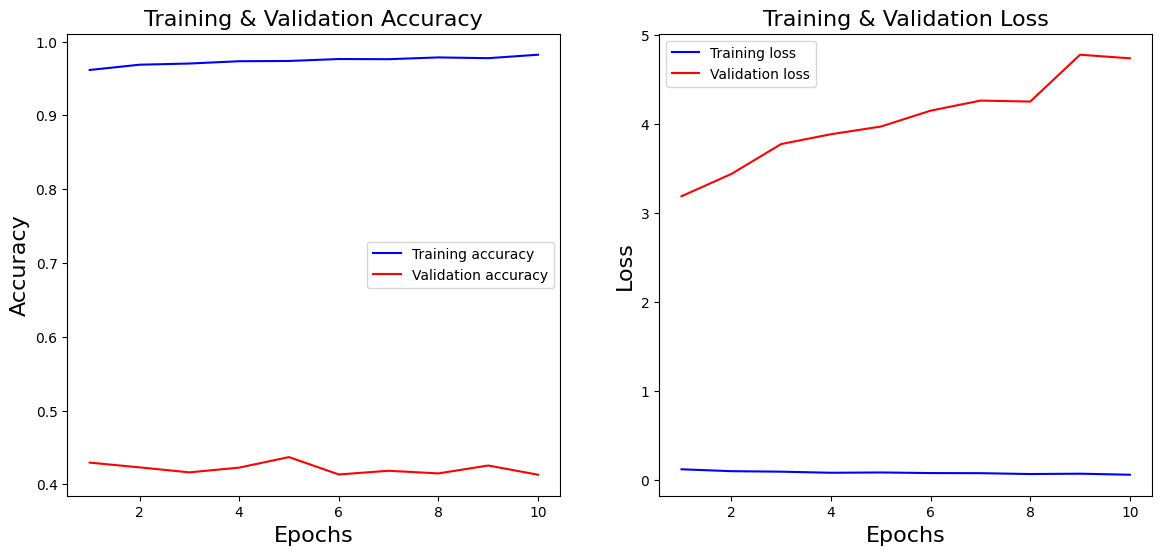

In [119]:
grafics1(hist_cnn_w2v)

In [ ]:
plot_metrics(cnn_w2v, encoded_x_val, y_val)

## Bi-LSTM

In [36]:
recurrent_dropout = 0.2
dropout_embed = 0.2
dense_dropout = 0.2



bi_lstm = Sequential()
bi_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)))
# SpatialDropout1D aplica dropout sobre embeddings completos (mejor que el dropout clásico aquí)
bi_lstm.add(SpatialDropout1D(dropout_embed))
bi_lstm.add(Bidirectional(LSTM(64, dropout=dense_dropout, recurrent_dropout=recurrent_dropout)))
bi_lstm.add(Dense(32, activation='relu'))
bi_lstm.add(Dropout(dense_dropout))
bi_lstm.add(Dense(4, activation='sigmoid'))
bi_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
bi_lstm.summary()



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 170, 300)       │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 170, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,191,140 (115.17 MB)

 Trainable params: 30,191,140 (115.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 5
batch_size=32
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_bi_lstm = bi_lstm.fit(encoded_x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(encoded_x_val, y_val), verbose=1, callbacks=[es])

# Metricas básicas
loss, acc = bi_lstm.evaluate(encoded_x_val, y_val, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 235s 335ms/step - accuracy: 0.4380 - loss: 1.2276 - val_accuracy: 0.5595 - val_loss: 1.0286
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 237s 338ms/step - accuracy: 0.7251 - loss: 0.7425 - val_accuracy: 0.5720 - val_loss: 1.0322
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 238s 340ms/step - accuracy: 0.8538 - loss: 0.4228 - val_accuracy: 0.5577 - val_loss: 1.2726
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 268s 381ms/step - accuracy: 0.9168 - loss: 0.2454 - val_accuracy: 0.5460 - val_loss: 1.5610
Test loss: 1.0380
Test accuracy: 0.5600


Test loss: 1.0380
Test accuracy: 0.5600

Accuracy (sklearn): 0.5600

Classification Report:
              precision    recall  f1-score   support

           0     0.5604    0.5292    0.5444       684
           1     0.5788    0.6376    0.6068       916
           2     0.5749    0.5981    0.5862       841
           3     0.4440    0.3361    0.3826       366

    accuracy                         0.5600      2807
   macro avg     0.5395    0.5252    0.5300      2807
weighted avg     0.5556    0.5600    0.5562      2807



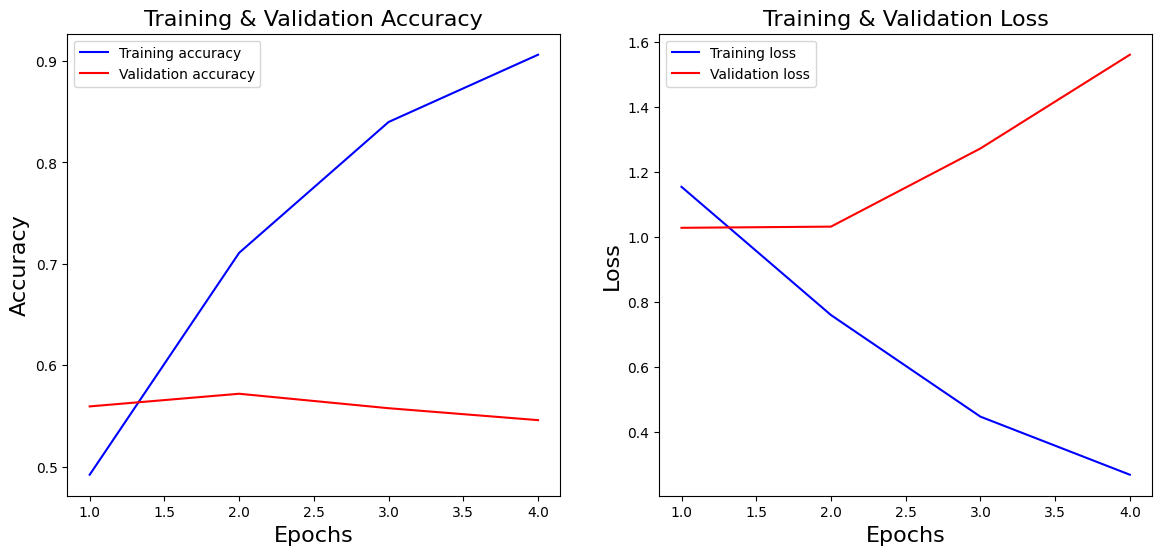

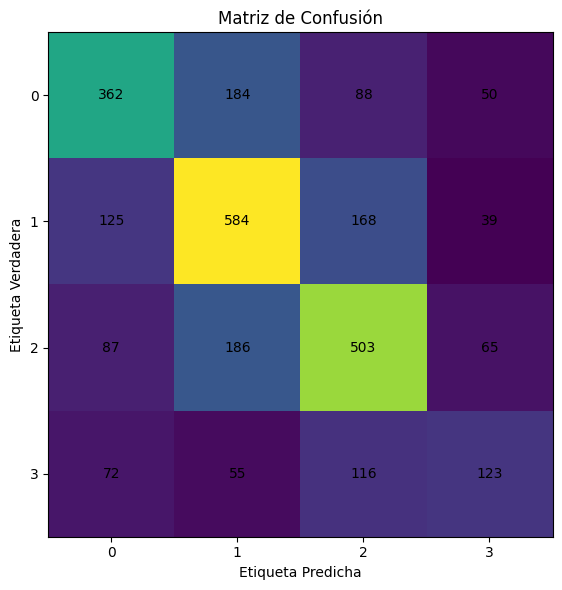

In [ ]:
grafics1(hist_bi_lstm)
plot_metrics(bi_lstm, encoded_x_val, y_val)

# TRANSFORMER

In [50]:
import numpy as np

vocab_size = 100000
embedding_dim = 100
max_length = max_length_texts = int(np.percentile(df_train['len_texts'], 80))
processor = TweetProcessor(remove_emojis=False, remove_mentions=True)

X = df_train['tweet']
y = df_train['ideology_encoded'].values
val_x = df_dev['tweet']
val_y = df_dev['ideology_encoded'].values
seed = 42

vocab = processor.build_vocab(X, vocab_size)                  # processor ya instanciado antes TweetProcessor

In [ ]:

model_id = "dccuchile/bert-base-spanish-wwm-cased"  # Modelo en español

tokenizer = AutoTokenizer.from_pretrained(model_id)



In [52]:

# Marcamos el tamaño maximo para truncar los textos

MAX_LENGTH = 128

print("Tamaño máximo :", MAX_LENGTH)


Tamaño máximo : 128


In [53]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

In [ ]:


# X,y para train, df_dev para validation

train_dataset = Dataset.from_dict({"text": X, "label": y.tolist()})
val_dataset = Dataset.from_dict({"text": df_dev['tweet'].tolist(), "label": df_dev['ideology_encoded'].tolist()})

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
})

encoded_data = dataset_dict.map(tokenize, batched=True) # Al mapear con tokenize, se aplica a cada tweet y se hace el encode
encoded_data.set_format("torch") # Nos aseguramos de que el formato sea compatible con PyTorch
train_dataset = encoded_data["train"]
validation_dataset = encoded_data["validation"]


Map: 100%|██████████| 4678/4678 [00:00<00:00, 20466.51 examples/s]


In [ ]:


model_id = "dccuchile/bert-base-spanish-wwm-cased"  # Modelo BERT en español
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

args = TrainingArguments(
    output_dir="./outputs",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    report_to="none"
) # Ponemos a punto todos los hiperparametros del modelo

In [ ]:


def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:

# Para crear un objeto de tipo Trainer hay que pasar el modelo, los conjuntos de entrenamiento y validación, los argumentos y la función para calcular
# las métricas.

trainer = Trainer(
    model = model,            # modelo que será ajustado
    
    train_dataset = train_dataset ,  # conjunto training
    eval_dataset = validation_dataset,  # conjunto de validación

    args = args,     # hiperparámetros
    compute_metrics=compute_metrics,    # función para computar las métricas
)


In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.125700,0.959125,0.594485,0.562501,0.618064,0.566524
2,0.658100,0.912672,0.655408,0.636873,0.639527,0.635468
3,0.280600,1.165170,0.647713,0.628035,0.640334,0.622585


TrainOutput(global_step=2634, training_loss=0.6657147389428582, metrics={'train_runtime': 504.24, 'train_samples_per_second': 166.974, 'train_steps_per_second': 5.224, 'total_flos': 5538258276295680.0, 'train_loss': 0.6657147389428582, 'epoch': 3.0})

In [61]:
trainer.evaluate()

{'eval_loss': 1.1651699542999268,
 'eval_accuracy': 0.6477126977340744,
 'eval_f1': 0.6280346816388536,
 'eval_precision': 0.6403339524251412,
 'eval_recall': 0.6225854541975554,
 'eval_runtime': 8.0833,
 'eval_samples_per_second': 578.726,
 'eval_steps_per_second': 18.186,
 'epoch': 3.0}

# ENFOQUE FINAL: DATA AUG + FINETUNING

In [62]:
counts = df_train['ideology_multiclass'].value_counts()
print(counts)
max_count = counts.max()
print(max_count)



ideology_multiclass
moderate_left     9158
moderate_right    8412
left              6839
right             3656
Name: count, dtype: int64
9158


In [ ]:


aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, n_aug=1):
    augmented_texts = [aug.augment(text) for _ in range(n_aug)]
    return augmented_texts


dfs = []

for label, group in df_train.groupby('ideology_multiclass'):
    n_samples = len(group)
    n_needed = max_count - n_samples
    
    dfs.append(group)  # añadir todos los originales
    
    if n_needed > 0:
        # Para generar aumentos, calculamos cuántos tweets aumentar por muestra
        n_aug_per_sample = max(1, n_needed // n_samples)
        
        augmented_texts = []
        augmented_rows = []
        
        for _, row in group.iterrows():
            aug_texts = augment_text(row['tweet'], n_aug=n_aug_per_sample)
            for aug_text in aug_texts:
                new_row = row.copy()
                new_row['tweet'] = aug_text
                augmented_rows.append(new_row)
                if len(augmented_rows) >= n_needed:
                    break
            if len(augmented_rows) >= n_needed:
                break
        
        dfs.append(pd.DataFrame(augmented_rows))

balanced_df = pd.concat(dfs).reset_index(drop=True)


b_counts = balanced_df['ideology_multiclass'].value_counts()
print(b_counts)

ideology_multiclass
left              9158
moderate_left     9158
moderate_right    9158
right             7312
Name: count, dtype: int64


In [ ]:

vocab_size = 100000
embedding_dim = 100
max_length = max_length_texts = int(np.percentile(balanced_df['len_texts'], 80))
processor = TweetProcessor(remove_emojis=False, remove_mentions=True)

X = balanced_df['tweet'].astype(str).tolist()
y = balanced_df['ideology_encoded'].values
val_x = df_dev['tweet']
val_y = df_dev['ideology_encoded'].values
seed = 42

vocab = processor.build_vocab(X, vocab_size)                  # processor ya instanciado antes TweetProcessor

In [ ]:

model_id = "dccuchile/bert-base-spanish-wwm-cased"  # Modelo en español

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [67]:

# Marcamos el tamaño maximo para truncar los textos

MAX_LENGTH = 128

print("Tamaño máximo :", MAX_LENGTH)


Tamaño máximo : 128


In [68]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

In [ ]:

# X,y para train, df_dev para validation

train_dataset = Dataset.from_dict({"text": X, "label": y.tolist()})
val_dataset = Dataset.from_dict({"text": df_dev['tweet'].tolist(), "label": df_dev['ideology_encoded'].tolist()})

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
})

encoded_data = dataset_dict.map(tokenize, batched=True) # Al mapear con tokenize, se aplica a cada tweet y se hace el encode
encoded_data.set_format("torch") # Nos aseguramos de que el formato sea compatible con PyTorch
train_dataset = encoded_data["train"]
validation_dataset = encoded_data["validation"]


Map: 100%|██████████| 4678/4678 [00:00<00:00, 17796.64 examples/s]


In [ ]:

model_id = "dccuchile/bert-base-spanish-wwm-cased"  # Modelo BERT en español
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:


args = TrainingArguments(
    output_dir="./outputs",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    report_to="none"
) # Ponemos a punto todos los hiperparametros del modelo

In [ ]:



def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:

# Para crear un objeto de tipo Trainer hay que pasar el modelo, los conjuntos de entrenamiento y validación, los argumentos y la función para calcular
# las métricas.



trainer = Trainer(
    model = model,            # modelo que será ajustado
    
    train_dataset = train_dataset ,  # conjunto training
    eval_dataset = validation_dataset,  # conjunto de validación

    args = args,     # hiperparámetros
    compute_metrics=compute_metrics,    # función para computar las métricas
)


In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.876100,0.901458,0.623557,0.602570,0.616780,0.597274
2,0.504100,0.974419,0.649209,0.630284,0.638667,0.628215
3,0.191500,1.294278,0.650492,0.626609,0.654109,0.615835


TrainOutput(global_step=3264, training_loss=0.5596683726591223, metrics={'train_runtime': 622.9286, 'train_samples_per_second': 167.528, 'train_steps_per_second': 5.24, 'total_flos': 6864559144814592.0, 'train_loss': 0.5596683726591223, 'epoch': 3.0})

In [75]:
trainer.evaluate()

{'eval_loss': 1.2942776679992676,
 'eval_accuracy': 0.6504916631038905,
 'eval_f1': 0.6266091325007075,
 'eval_precision': 0.6541088968380766,
 'eval_recall': 0.6158348744293473,
 'eval_runtime': 8.0453,
 'eval_samples_per_second': 581.46,
 'eval_steps_per_second': 18.272,
 'epoch': 3.0}

# Labels de Test Cleaned

In [ ]:

# Cambiar por el directorio usado
test_df = pd.read_csv(r"PracticaPLN\datasets\testCleaned.csv")

In [80]:
test_tweets = test_df["tweet"].astype(str).tolist()
test_ids = test_df["id"].tolist()

In [81]:
test_dataset = Dataset.from_dict({"text": test_tweets})
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset.set_format("torch")

Map: 100%|██████████| 4678/4678 [00:00<00:00, 17930.93 examples/s]


In [82]:
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

In [84]:
output = pd.DataFrame({"id": test_ids, "label": pred_labels})
output.to_csv("TestPrediction.csv", index=False)